# Modeling Aboveground Biomass Density Using GEDI, Sentinel Imagery, and Machine Learning: An Introductory Guide with Python
## Aim
The script aims to model aboveground biomass density (AGBD) using the Global Ecosystem Dynamics Investigation (GEDI) Level 4A (L4A) dataset, Sentinel-1 (S1), Sentinel-2 (S2), spectral indices, Shuttle Radar Topography Mission (SRTM) digital elevation model (elevation and slope), and a random forest method. We use Mafungautsi Forest Reserve as the test site.

## Requirements
To run this script, the user must have an Earth Engine account. In addition, the user must authenticate the Earth Engine Python API. See the instructions [here](https://developers.google.com/earth-engine/guides/auth).


This script will use the [geemap](https://geemap.org) Python package to visualize, analyze and compute AGBD. Geemap enables users to interactively explore and visualize Earth Engine datasets within a Jupyter-based environment with minimal coding. To learn more about geemap, check out https://geemap.org.

Following are the steps to model AGBD.

# Initialize and Authenticate Earth Engine
To get started with Google Earth Engine (GEE), you need to initialize and authenticate the Earth Engine API. Follow these steps.


First, import the Earth Engine API by importing the ee module into your Python environment. This module allows you to interact with the Earth Engine platform.


In [1]:
# Import the API
import ee

Next, initialize the Earth Engine API. You must initialize the API to use Earth Engine functionalities. This involves authenticating your session and initializing the library. When you run the ee.Initialize() command for the first time, you might be prompted to authenticate your session. This will open a web browser window where you need to log in with your Google account and grant Earth Engine access.

In [2]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-xxx-test') # Change to your EE project

## Import Libraries
Next, import the essential libraries needed to process and analyze the datasets.

In [3]:
# Import the necessary libraries
import geemap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geemap import chart

# Import Datasets
## Import the project boundary
First, import the forest reserve project boundary from the Google Earth Engine catalog's World Database on Protected Areas ('WCMC/WDPA/current/polygons'). The World Database on Protected Areas (WDPA) is the most up-to-date and comprehensive source of information on protected areas, updated monthly with submissions from governments, non-governmental organizations, landowners, and communities. It is managed by the United Nations Environment Programme's World Conservation Monitoring Centre (UNEP-WCMC) with support from the IUCN and its World Commission on Protected Areas (WCPA). You can select your project forest reserve or protected area from the WDPA database.

Source: https://developers.google.com/earth-engine/datasets/catalog/WCMC_WDPA_current_polygons



In [4]:
## Use the code below to search for the forest reserve or protected area in your country of interest.
# Load the WDPA data
protected_areas = ee.FeatureCollection('WCMC/WDPA/current/polygons')

# Filter for protected areas in Zimbabwe
zimbabwe_protected_areas = protected_areas.filter(ee.Filter.eq('PARENT_ISO', 'ZWE'))

# Select the 'NAME' property of the features
names = zimbabwe_protected_areas.aggregate_array('NAME')

# Print the names of the protected areas
print(names.getInfo())

['Mana Pools National Park, Sapi and Chewore Safari Areas', 'Ewanrrig', 'National Botanic', 'Vumba', 'Vumba', 'Bunga Forest', 'Rusitu Forest', 'Haroni Forest', 'Tingwa Raphia Palm', 'Mazowe', 'Chisekera Hot Springs', 'Mawari Raphia Palm', 'Pioneer, Tolo River, South Camp', 'Sebakwe', 'Bubye Valley Conservancy', 'Gwayi Conservancy', 'Midlands Black Rhino Conservancy', 'Bubiana', 'Chiredzi River Conservancy', 'Malilangwe Conservancy', 'Save Conservancy', 'Gonarezhou', 'Chizarira', 'Matusadona', 'Matopos', 'Nyanga', 'Kazuma Pan', 'Hwange', 'Victoria Falls', 'Zambezi', 'Mana Pools', 'Chimanimani', 'Kyle', 'Ngezi', 'Sebakwe', 'Lake Kariba', 'Darwendale', 'Lake Chivero', 'Bangala', 'Umzingwane', 'Manjirenji', 'Chinhoyi Caves', 'Mupfure', 'Kavira', 'Osborne', 'Lake Cunningham', 'Chete', 'Chirisa', 'Charara', 'Chewore', 'Sapi', 'Hurungwe', 'Dande', 'Matetsi', 'Tuli', 'Sibilobilo SA', 'Umfurudzi', 'Chegutu', 'Doma', 'Chipinge', 'Deka', 'Malipati', 'Mushandike', 'Tshabalala', 'Manjinji Pan', 'Ny

Next, select your project boundary. We will use the Mafungautsi Forest Reserve in Zimbabwe.

In [5]:
# Define the boundary for Mafungabusi forest reserve
boundary = ee.FeatureCollection('WCMC/WDPA/current/polygons') \
    .filter(ee.Filter.inList('NAME', ['Mafungabusi']))

## Create Sentinel-2 composite
The sentinel-2 mission offers a wide-swath, high-resolution, multispectral imaging capability with a global 5-day revisit frequency. The Sentinel-2 Multispectral Instrument (MSI) has 13 spectral bands, providing a comprehensive view of the Earth's surface. These bands are distributed as four at 10 meters, six at 20 meters, and three at 60 meters spatial resolution. For more detailed information about the Sentinel-2 mission, please visit https://sentinel.esa.int/web/sentinel/missions/sentinel-2.


In [25]:
# Load Sentinel-2 spectral reflectance data.
s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

# Create a function to mask clouds using the Sentinel-2 QA band.
def maskS2clouds(image):
    qa = image.select('QA60')
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = ee.Number(2).pow(10).int()
    cirrusBitMask = ee.Number(2).pow(11).int()
    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
        qa.bitwiseAnd(cirrusBitMask).eq(0))
    # Return the masked and scaled data.
    return image.updateMask(mask).divide(10000)

# Create a single composite image for a given period.
start_date = '2021-01-01'
end_date = '2021-04-30'

# Filter clouds from Sentinel-2 for the given period.
composite = s2.filterDate(start_date, end_date) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
    .map(maskS2clouds) \
    .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12'])  # Select bands for display

# Compute the median composite and clip to the boundary.
S2_composite = composite.median().clip(boundary)

# Initialize our map.
map1 = geemap.Map()
map1.centerObject(boundary, 12)

# Add the composite image to the map with specified display settings.
map1.addLayer(S2_composite, {'bands': ['B11', 'B8', 'B3'], 'min': 0, 'max': 0.3}, 'Sentinel-2 Composite')

# Display the map with layer control.
map1.addLayerControl()
map1

Map(center=[-18.43596873133084, 28.869046137098042], controls=(WidgetControl(options=['position', 'transparent…

## Compute spectral indices
In this tutorial, we will utilize the normalized difference vegetation index (NDVI), soil-adjusted vegetation index (SAVI), and the red edge spectral index (RESI). Next, calculate NDVI, SAVI, and RESI.

In [26]:
# Calculate NDVI
ndvi = S2_composite.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Calculate SAVI.
L = 0.5  # Soil adjustment factor, typically between 0 and 1
savi = S2_composite.expression(
    '((NIR - Red) / (NIR + Red + L)) * (1 + L)', {
        'NIR': S2_composite.select('B8'),
        'Red': S2_composite.select('B4'),
        'L': L
    }).rename('SAVI')

# Calculate RESI
resi = S2_composite.expression(
    '((RE3 + RE2 - RE1) / (RE3 + RE2 + RE1))', {
        'RE1': S2_composite.select('B5'),
        'RE2': S2_composite.select('B6'),
        'RE3': S2_composite.select('B7')
    }).rename('RESI')

# Initialize our map.
map2 = geemap.Map()
map2.centerObject(boundary, 12)

# Add the NDVI and RESI layers to the map.
map2.addLayer(ndvi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'NDVI')
map2.addLayer(savi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'SAVI')
map2.addLayer(resi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'RESI')

# Display the map with layer control.
map2.addLayerControl()
map2

Map(center=[-18.43596873133084, 28.869046137098042], controls=(WidgetControl(options=['position', 'transparent…

## Load other datasets
Import other datasets such as the Shuttle Radar Topography Mission (SRTM) digital elevation model (DEM). Add the SRTM DEM data and calculate slope.

In [8]:
# Load SRTM DEM
SRTM = ee.Image("USGS/SRTMGL1_003")

# Clip Elevation to the boundary
elevation = SRTM.clip(boundary)

# Derive slope from the SRTM
slope = ee.Terrain.slope(SRTM).clip(boundary)

# Compute the minimum and maximum elevation values within the boundary.
min_elevation = elevation.reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=boundary,
    scale=30,
    maxPixels=1e9
).get('elevation').getInfo()

max_elevation = elevation.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=boundary,
    scale=30,
    maxPixels=1e9
).get('elevation').getInfo()

print(f"Min Elevation: {min_elevation}, Max Elevation: {max_elevation}")

# Initialize our map.
map3 = geemap.Map()
map3.centerObject(boundary, 12)

# Define attractive color gradients for elevation and slope
elevationPalette = ['006633', '99cc00', 'ffff00', 'ff9900', 'ff6600', 'ff3333', 'ff0000', 'cc0000', '990000', '660000', '330000', '000000']
slopePalette = ['440154', '482878', '3E4A89', '31688E', '26838F', '1F9D8A', '6CCE59', 'B6DE2B', 'FDE724']

# Add elevation layer to the map with new palette
vis_params_elevation = {'min': min_elevation, 'max': max_elevation, 'palette': elevationPalette}
map3.addLayer(elevation, vis_params_elevation, 'Elevation')

# Add slope layer to the map with new palette
vis_params_slope = {'min': 0, 'max': 60, 'palette': slopePalette}
map3.addLayer(slope, vis_params_slope, 'Slope')

# Display the map with layer control.
map3.addLayerControl()
map3

Min Elevation: 1112, Max Elevation: 1341


Map(center=[-18.43596873133084, 28.869046137098042], controls=(WidgetControl(options=['position', 'transparent…

## Load Sentinel-1 data
The Sentinel-1 mission provides dual-polarization C-band Synthetic Aperture Radar (SAR) data at 5.405 GHz. This collection includes Sentinel-1 Ground Range Detected (GRD) scenes that are processed using the Sentinel-1 Toolbox to produce calibrated, ortho-corrected products. The data is updated daily, with new assets available within two days. Scenes have resolutions of 10, 25, or 40 meters and include up to two of four polarization bands (VV, HH, VV+VH, HH+HV), as well as an 'angle' band representing incidence angles. Pre-processing steps include thermal noise removal, radiometric calibration, and terrain correction, converting values to decibels. For raw power values, users can refer to the COPERNICUS/S1_GRD_FLOAT collection.


In this tutorial, we will visuaize VV, VH, Sentinel-1 SAR imagery in false color mode to enhance the interpretation of different surface features. A common technique for creating these visualizations is RGB decomposition, where the red channel represents co-polarized backscatter (VV), the green channel represents cross-polarized backscatter (VH), and the blue channel represents the ratio of cross-polarized to co-polarized backscatter (VH/VV). This color scheme typically results in blue areas indicating low backscatter in both polarizations, such as calm water, dry sand, or frozen ground; green areas highlighting high cross-polarization values, which are often associated with vegetation or volume scatterers; and red areas showing low cross-polarization but high co-polarization, commonly found in urban areas or sparsely vegetated landscapes.

In [33]:
# Load Sentinel-1 data
s1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .filterBounds(boundary)

# Create a median composite for VV and VH
vv = s1.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')).select('VV').median().clip(boundary)
vh = s1.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')).select('VH').median().clip(boundary)

# Visualize VV and VH backscatter
map4 = geemap.Map()
map4.centerObject(boundary, 12)

# Visualization parameters for VV and VH
vv_vis_params = {'min': -20, 'max': 0, 'palette': ['white', 'black']}
vh_vis_params = {'min': -25, 'max': 0, 'palette': ['white', 'black']}

# Add VV and VH layers to the map
map4.addLayer(vv, vv_vis_params, 'VV Backscatter')
map4.addLayer(vh, vh_vis_params, 'VH Backscatter')

# Calculate the ratio of VH to VV
vv_vh_ratio = vv.divide(vh).rename('VV/VH')

# Create a false-color composite
false_color = ee.Image.rgb(vv,vh,vv_vh_ratio)

# Visualization parameters for false-color composite
false_color_vis_params = {'min': [-20, -25, 0], 'max': [0, 0, 1]}

# Add the false-color composite to the map
map4.addLayer(false_color, false_color_vis_params, 'False-Color Composite (VV, VH, VV/VH)')

# Display the map with layer control
map4.addLayerControl()
map4

Map(center=[-18.43596873133096, 28.86904613709809], controls=(WidgetControl(options=['position', 'transparent_…

# Prepare datasets for modeling
## Merge all predictor variables
Combine Sentinel-2 bands, spectral indices (NDVI, SAVI, RESI), elevation (SRTM DEM), and slope.

In [34]:
# Merge the predictor variables
mergedCollection = (
    S2_composite
    .addBands(ndvi)
    .addBands(savi)
    .addBands(resi)
    .addBands(elevation)
    .addBands(slope)
    .addBands(vv.rename('VV'))
    .addBands(vh.rename('VH'))
)

# Clip the output image to the farm boundary
clippedmergedCollection = mergedCollection.clipToCollection(boundary)

# Bands to include in the regression
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12', 'NDVI', 'SAVI', 'RESI', 'elevation', 'slope', 'VV', 'VH']

## Extract AGBD from GEDI Level 4A
Derive aboveground biomass density (AGBD) from GEDI Level 4A (L4A) dataset. This dataset contains AGBD predictions in Mg/ha. More information about this dataset is available at: https://developers.google.com/earth-engine/datasets/catalog/LARSE_GEDI_GEDI04_A_002.

In [35]:
# Define the date range
start_date = '2021-01-01'
end_date = '2021-05-30'

# Prepare the mask
def qualityMask(im):
    return im.updateMask(im.select('l4_quality_flag').eq(1)) \
             .updateMask(im.select('degrade_flag').eq(0))

# Load the GEDI Level 4A (L4A) dataset with date filtering
dataset = ee.ImageCollection('LARSE/GEDI/GEDI04_A_002_MONTHLY') \
    .filterDate(start_date, end_date) \
    .map(qualityMask) \
    .select('agbd') \
    .filterBounds(boundary)

# Clip the dataset to the boundary
clippedDataset = dataset.mosaic().clipToCollection(boundary)

# Create the display parameters
gediVis = {
    'min': 1,
    'max': 300,
    'palette': 'red, green, blue',
}

# Sample the training points (ta) from the dataset
samplePoints = clippedDataset.sample(
    region=boundary,
    scale=30,
    geometries=True
)

# Get the AGDB values from the 'agbd' property of the filtered points
agbd_values = samplePoints.aggregate_array('agbd').getInfo()

# Calculate summary statistics
mean_agbd = np.mean(agbd_values)
median_agbd = np.median(agbd_values)
std_agbd = np.std(agbd_values)
min_agbd = np.min(agbd_values)
max_agbd = np.max(agbd_values)

# Print the summary statistics
print("Mean AGBD:", mean_agbd)
print("Median AGBD:", median_agbd)
print("Standard Deviation AGBD:", std_agbd)
print("Minimum AGBD:", min_agbd)
print("Maximum AGBD:", max_agbd)

# Print and display the training (ta) points derived from the GEDI L4B dataset
print(samplePoints.size().getInfo())
print(samplePoints.first().getInfo())

Mean AGBD: 42.89413022046278
Median AGBD: 42.399749755859375
Standard Deviation AGBD: 31.279886849288665
Minimum AGBD: 0.787926971912384
Maximum AGBD: 222.598434
3375
{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [29.0039504941312, -18.530312933524872]}, 'id': '0', 'properties': {'agbd': 1.2719420194625854}}


## Display GEDI Level 4A AGBD
Next, display GEDI AGBD sample points.

In [36]:
# Display the GEDI L4A mean above-ground biomass (AGB) points and the derived training points
# Initialize the map
map4 = geemap.Map()
map4.centerObject(boundary, 12)
map4.addLayer(clippedDataset, gediVis, 'GEDI L4A Mean AGBD points')
map4.addLayer(samplePoints, {'color': '808080'}, 'Mean AGBD training points')
# Display the map
display(map4)

The provided color (red, green, blue) is invalid. Using the default black color.
'#red, green, blue' is not in web format. Need 3 or 6 hex digit.


Map(center=[-18.43596873133084, 28.869046137098042], controls=(WidgetControl(options=['position', 'transparent…

# Modeling AGBD using Random Forests
## Prepare training and testing data
In this step, we select the specific bands fro the merged predictor variables (ClippedmergedCollection) and sample values at the locations of the training(trainingData) points.


In [37]:
# Select specific bands from the 'clippedmergedCollection'
# and sample the values at the locations of the 'trainingData' points.
# 'clippedmergedCollection' is the Earth Engine ImageCollection containing the satellite imagery,
# and 'bands' is a list of specific bands to be selected.
trainingData = clippedmergedCollection.select(bands).sampleRegions(**{
    'collection': samplePoints,  # The 'trainingData' is the FeatureCollection containing training points.
    'properties': ['agbd'],  # The property 'agbd' is used as the label for the training points.
    'scale': 30  # The scale (resolution) at which the sampling is performed (in meters).
})

Split training datasets into training and testing sets. Then check the size of the training and testing data.

In [38]:
# Split training data into training and testing sets
# Add a random column (named random) and specify the seed value for repeatability
split = 0.7
trainingSet = trainingData.randomColumn('random', 27)
training = trainingSet.filter(ee.Filter.lessThan('random', split))
testing = trainingSet.filter(ee.Filter.greaterThanOrEquals('random', split))

# Check training data set
print(training.size().getInfo())
print(training.first().getInfo())

# Check the size of the testing data
print(testing.size().getInfo())
print(testing.first().getInfo())

2423
{'type': 'Feature', 'geometry': None, 'id': '2_0', 'properties': {'B11': 0.3564000129699707, 'B12': 0.29499998688697815, 'B2': 0.0689999982714653, 'B3': 0.10480000078678131, 'B4': 0.1526000052690506, 'B5': 0.20360000431537628, 'B6': 0.27869999408721924, 'B7': 0.3043999969959259, 'B8': 0.3163999915122986, 'NDVI': 0.34925371408462524, 'RESI': 0.482394814491272, 'SAVI': 0.2535603510639775, 'VH': -21.80207543162888, 'VV': -15.219832962153523, 'agbd': 1.214100956916809, 'elevation': 1315, 'random': 0.3442401731175879, 'slope': 0}}
952
{'type': 'Feature', 'geometry': None, 'id': '0_0', 'properties': {'B11': 0.33880001306533813, 'B12': 0.2808000147342682, 'B2': 0.0649000033736229, 'B3': 0.09749999642372131, 'B4': 0.13979999721050262, 'B5': 0.17900000512599945, 'B6': 0.2590000033378601, 'B7': 0.28439998626708984, 'B8': 0.29429998993873596, 'NDVI': 0.3559087812900543, 'RESI': 0.5044296383857727, 'SAVI': 0.24809976692069471, 'VH': -18.793500255166908, 'VV': -10.132171781411476, 'agbd': 1.27

## Run the random forest model
Model AGBD using a random forest (RF) method.

In [39]:
# Set the initial RF model parameters
init_params = {"numberOfTrees":500, # the number of individual decision tree models
              "variablesPerSplit":None,  # the number of features to use per split
              "minLeafPopulation":1, # smallest sample size possible per leaf
              "bagFraction":0.5, # fraction of data to include for each individual tree model
              "maxNodes":None, # max number of leafs/nodes per tree
               "seed":27}  # random seed for "random" choices like sampling. Setting this allows others to reproduce your exact results even with stocastic parameters

# Perform the random forest regression
rf_regressor = ee.Classifier.smileRandomForest(**init_params) \
    .setOutputMode('REGRESSION') \
    .train(**{
        'features': training,
        'classProperty': 'agbd',
        'inputProperties': bands
    })

Create a feature importance graph.

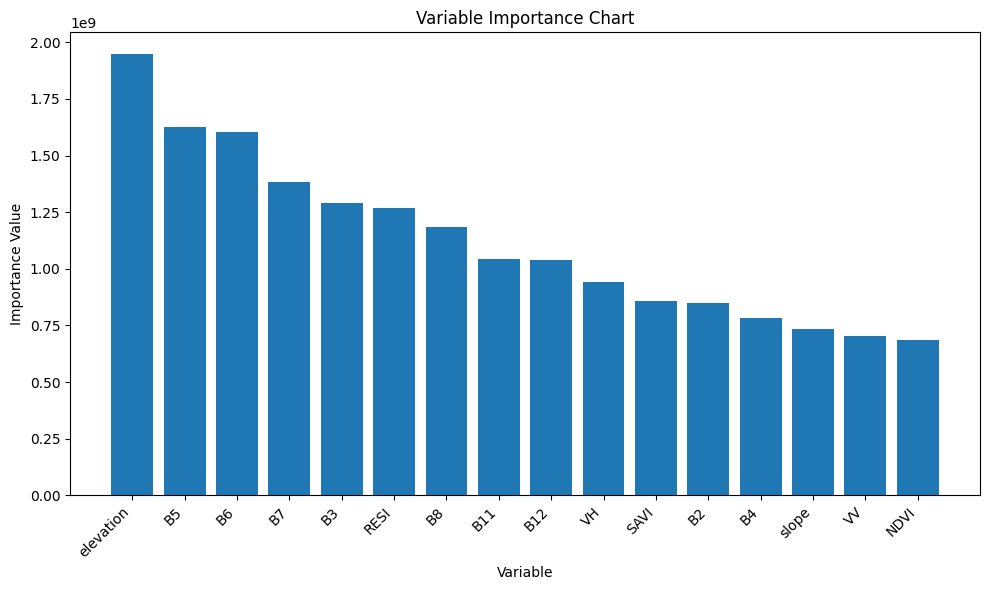

In [40]:
# Get details of classifier
regressor_details = rf_regressor.explain()

# Explain the classifier with importance values
variable_importance = ee.Dictionary(regressor_details).get('importance')

# Convert the variable importance dictionary to a list of tuples
variable_importance_list = variable_importance.getInfo().items()

# Sort the list by importance values
sorted_variable_importance = sorted(variable_importance_list, key=lambda x: x[1], reverse=True)

# Extract labels and values for the chart
labels = [item[0] for item in sorted_variable_importance]
values = [item[1] for item in sorted_variable_importance]

# Create a bar chart using matplotlib
plt.figure(figsize=(10, 6))
plt.bar(labels, values)
plt.xlabel('Variable')
plt.ylabel('Importance Value')
plt.title('Variable Importance Chart')
plt.xticks(rotation=45, ha='right')

# Display the chart
plt.tight_layout()
plt.show()

# Check Model Performance
## Check the RF model performance using the training set.
Generate sample points for the training and predicted AGBD. Next, compute RMSE for the training set.

RMSE: 13.499850171259839
R²: 0.8450713546132643


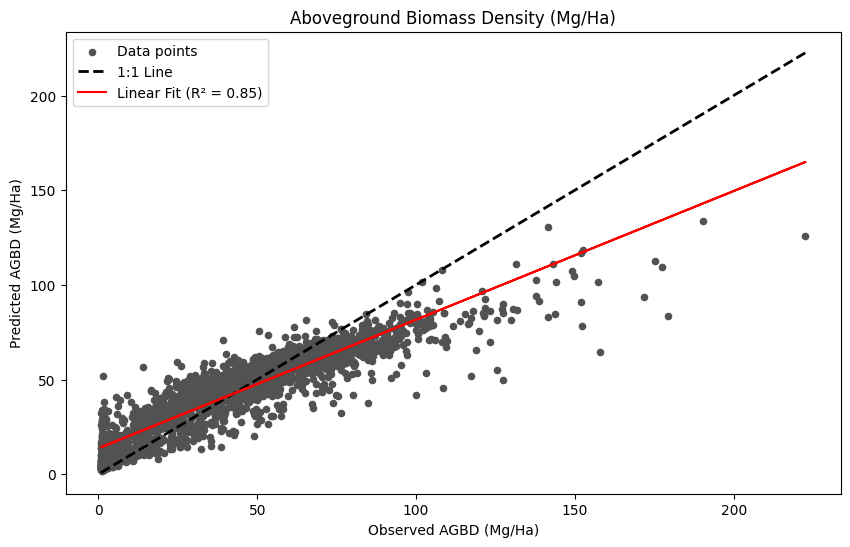

In [41]:
# Calculate RMSE
def calculate_rmse(input_fc):
    observed = ee.Array(input_fc.aggregate_array('agbd'))
    predicted = ee.Array(input_fc.aggregate_array('predicted'))
    rmse = observed.subtract(predicted).pow(2).reduce('mean', [0]).sqrt().get([0])
    return rmse

predicted_training = training.classify(rf_regressor, 'predicted')
rmse = calculate_rmse(predicted_training).getInfo()
print('RMSE:', rmse)

# Calculate R²
observed_values = np.array(predicted_training.aggregate_array('agbd').getInfo())
predicted_values = np.array(predicted_training.aggregate_array('predicted').getInfo())
r2 = np.corrcoef(observed_values, predicted_values)[0, 1] ** 2
print('R²:', r2)

# Create a plot of observed vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(observed_values, predicted_values, c='#525252', s=20, label='Data points')
plt.plot([observed_values.min(), observed_values.max()], [observed_values.min(), observed_values.max()], 'k--', lw=2, label='1:1 Line')

# Linear fit
slope, intercept = np.polyfit(observed_values, predicted_values, 1)
plt.plot(observed_values, slope * observed_values + intercept, 'r', label=f'Linear Fit (R² = {r2:.2f})')

plt.xlabel('Observed AGBD (Mg/Ha)')
plt.ylabel('Predicted AGBD (Mg/Ha)')
plt.title('Aboveground Biomass Density (Mg/Ha)')
plt.legend()
plt.show()

## Check the RF model performance using the test (validation) set.
Perform model validation for the test (validation) set.


Test RMSE: 21.93118901657559
Test R²: 0.5139119280432407


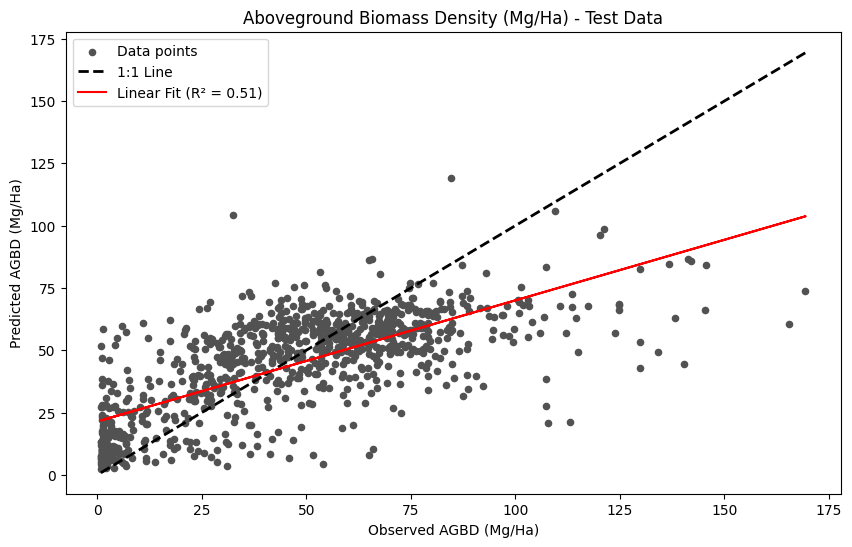

In [42]:
# Predict AGBD for the test data
predicted_testing = testing.classify(rf_regressor, 'predicted')
observed_testing_values = np.array(predicted_testing.aggregate_array('agbd').getInfo())
predicted_testing_values = np.array(predicted_testing.aggregate_array('predicted').getInfo())

# Calculate RMSE and R² for the validation data
rmse_testing = np.sqrt(mean_squared_error(observed_testing_values, predicted_testing_values))
r2_testing = r2_score(observed_testing_values, predicted_testing_values)
print('Test RMSE:', rmse_testing)
print('Test R²:', r2_testing)

# Create a plot of observed vs. predicted values for the test data
plt.figure(figsize=(10, 6))
plt.scatter(observed_testing_values, predicted_testing_values, c='#525252', s=20, label='Data points')
plt.plot([observed_testing_values.min(), observed_testing_values.max()], [observed_testing_values.min(), observed_testing_values.max()], 'k--', lw=2, label='1:1 Line')
slope, intercept = np.polyfit(observed_testing_values, predicted_testing_values, 1)
plt.plot(observed_testing_values, slope * observed_testing_values + intercept, 'r', label=f'Linear Fit (R² = {r2_testing:.2f})')
plt.xlabel('Observed AGBD (Mg/Ha)')
plt.ylabel('Predicted AGBD (Mg/Ha)')
plt.title('Aboveground Biomass Density (Mg/Ha) - Test Data')
plt.legend()
plt.show()

## Predict and Visualize AGBD
Let's predict the aboveground biomass density (AGBD) and then display the map.

In [43]:
# Predict AGBD
regression = clippedmergedCollection.select(bands).classify(rf_regressor, 'predicted').clip(boundary)

# Define a custom palette to display the AGBD map
palette = ['#FFFF00', '#ADFF2F', '#32CD32', '#2E8B57', '#006400']

# Prepare visualization parameters to display the AGBD regression on the map
viz = {
  'min': 0,
  'max': 220,
  'palette': palette}

# Initialize the map
map5 = geemap.Map()
map5.centerObject(boundary, 12)

# Add visualization parameters
map5.addLayer(regression, viz, 'AGBD map')
map5.add_colorbar(viz, label="AGBD (Mg/ ha)", layer_name="AGBD map")

# Display the AGBD map
map5

Map(center=[-18.43596873133084, 28.869046137098042], controls=(WidgetControl(options=['position', 'transparent…

## Export AGBD Map
Export the AGBD map to Google Drive.

In [ ]:
# Export the image, specifying scale and region.
task = ee.batch.Export.image.toDrive(**{
    'image': regression,
    'description': 'Mafungautsi_AGBD_S1_S2_2021',
    'folder':'export',
    'scale': 10,
    'region': boundary.geometry().getInfo()['coordinates'],
    'maxPixels': 1e10
})

task.start()

## Key Takeaways

The random forest model is overfitting because it performs significantly better on the training data than on the test data. Several factors may contribute to this overfitting in this case study. The next tutorial will focus on increasing the quality and quantity of GEDI L4A AGBD sample points. We will also analyze sensitivity to determine which scale provides the best model results.


## References


Horler, D. N. H., Dockray, M., & Barber, J. (1983). The red edge of plant leaf reflectance. International Journal of Remote Sensing, 4(2), 273-288. https://doi.org/10.1080/01431168308948546[4]


Huete, A. R. (1988). A soil-adjusted vegetation index (SAVI). Remote Sensing of Environment, 25, 295-309.


Macave, O. A., Ribeiro, N. S., Ribeiro, A. I., Chaúque, A., Bandeira, R., Branquinho, C., & Washington-Allen, R. (2022). Modelling aboveground biomass of Miombo woodlands in Niassa Special Reserve, Northern Mozambique. Forests, 13(2), 311. https://doi.org/10.3390/f13020311


Rouse, J. W., Jr., Haas, R. H., Schell, J. A., & Deering, D. W. (1974). Monitoring vegetation systems in the great plains with ERTS. In S. C. Fraden, E. P. Marcanti, & M. A. Becker (Eds.), Third ERTS-1 Symposium, 10–14 Dec. 1973, NASA SP-351 (pp. 309-317). NASA.


Xiao, C., Li, P., Feng, Z., Liu, Y., & Zhang, X. (2020). Sentinel-2 red-edge spectral indices (RESI) suitability for mapping rubber boom in Luang Namtha Province, northern Lao PDR. International Journal of Applied Earth Observation and Geoinformation, 93, 102176.